In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
! pip install -q kaggle

In [ ]:
! mkdir ~/.kaggle

In [ ]:
! cp /content/drive/MyDrive/kaggle/kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets list

ref                                                                 title                                        size  lastUpdated          downloadCount  voteCount  usabilityRating  
------------------------------------------------------------------  ------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
thedrcat/daigt-v2-train-dataset                                     DAIGT V2 Train Dataset                       29MB  2023-11-16 01:38:36           1964        191  1.0              
muhammadbinimran/housing-price-prediction-data                      Housing Price Prediction Data               763KB  2023-11-21 17:56:32           8790        152  1.0              
everydaycodings/produce-prices-dataset                              Fruits and Vegetables Prices Dataset        232KB  2023-12-11 13:40:33           1417         29  1.0              
thedevastator/books-sales-and-ratings                               Books Sales 

In [ ]:
!kaggle datasets download -d therealoise/bean-disease-dataset

 93% 122M/131M [00:01<00:00, 68.4MB/s]
100% 131M/131M [00:01<00:00, 70.6MB/s]


In [ ]:
import zipfile

In [ ]:
dataset_zip = zipfile.ZipFile('bean-disease-dataset.zip', 'r')
dataset_zip.extractall()

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme()

import tensorflow as tf

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

In [ ]:
def plot_training_curves(history, name):

    history = history.history

    plt.figure(figsize=(15, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history["loss"], label="Training loss")
    plt.plot(history["val_loss"], label="Validation loss")
    plt.legend()
    plt.xlabel("Epoch")
    plt.ylabel("Loss")

    plt.subplot(1, 2, 2)
    plt.plot(history["accuracy"], label="Training accuracy")
    plt.plot(history["val_accuracy"], label="Validation accuracy")
    plt.legend()
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")

    plt.suptitle(f"{name} Training performance")
    plt.show()

def predict(dataset, model, n_samples=100):
    batch = dataset.take(n_samples)
    predictions = []
    truth = []

    for img, label in batch:
        truth.append(label)
        pred = model.predict(img[tf.newaxis, ...], verbose=False)
        predictions.append(np.argmax(pred))

    predictions = np.array(predictions)
    truth = np.array(truth)

    return batch, predictions, truth


def performance_report(dataset, model, n_samples=100):

    batch, predictions, truth = predict(dataset, model, n_samples)

    plt.figure(figsize=(7, 7))
    ax = sns.heatmap(confusion_matrix(truth, predictions), annot=True, xticklabels=class_names, yticklabels=class_names)
    ax.set_title(f"Confusion Matrix ({len(batch)} samples)")
    plt.show()

    print("\n\nClassification Report:\n")
    print(classification_report(truth, predictions, labels=[0, 1, 2], target_names=class_names))

In [ ]:
data_path = "/content/Bean_Dataset"
class_names = ["angular_leaf_spot", "bean_rust", "healthy"]

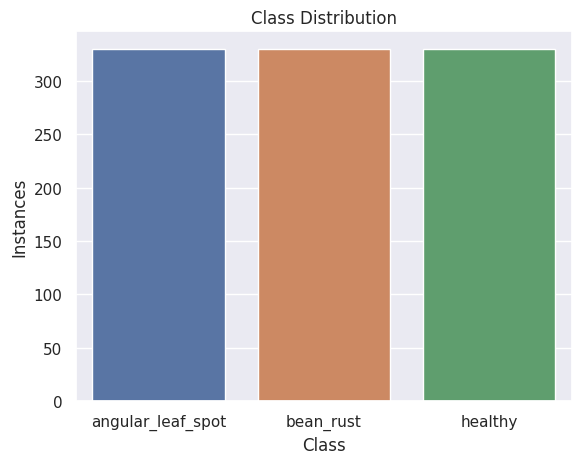

In [ ]:
counts = [len(os.listdir(os.path.join(data_path, class_name))) for class_name in class_names]

sns.barplot(x=class_names, y=counts)
plt.title("Class Distribution")
plt.xlabel("Class")
plt.ylabel("Instances")
plt.show()

In [ ]:
BATCH_SIZE = None
IMAGE_HEIGHT = 256
IMAGE_WIDTH = 256
SEED = 42

train_ds = tf.keras.utils.image_dataset_from_directory(
    data_path,
    batch_size=BATCH_SIZE,
    image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    shuffle=True,
    seed=SEED,
    validation_split=0.2,
    subset="training",
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    data_path,
    batch_size=BATCH_SIZE,
    image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    shuffle=True,
    seed=SEED,
    validation_split=0.2,
    subset="validation",
)

Found 990 files belonging to 3 classes.
Using 792 files for training.
Found 990 files belonging to 3 classes.
Using 198 files for validation.


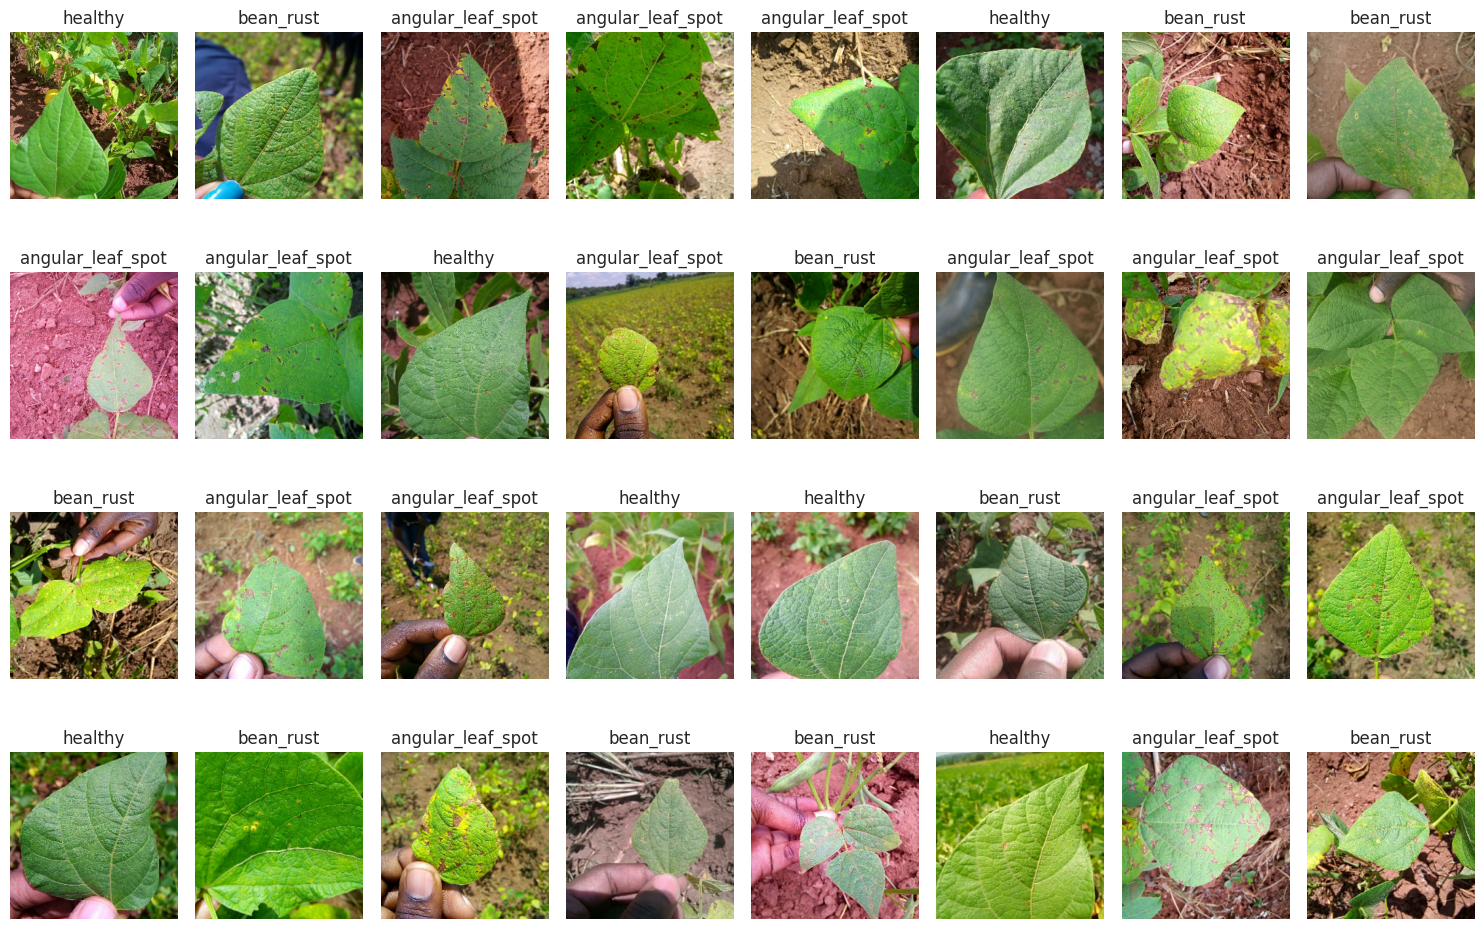

In [ ]:
fig, axs = plt.subplots(4, 8, figsize=(15, 10))

for (img, label), ax in zip(train_ds.take(32), axs.flatten()):
    ax.imshow(img.numpy().astype(np.int64))
    ax.set_title(class_names[label.numpy()])
    ax.axis("off")

plt.tight_layout()
plt.savefig("samples.png")
fig.show()

In [ ]:
BUFFER_SIZE = 1000
BATCH_SIZE = 32

train_batches = (
    train_ds
    .cache()
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE)
    .prefetch(buffer_size=tf.data.AUTOTUNE))

val_batches = val_ds.batch(BATCH_SIZE)

In [ ]:
def conv_block(x, n_filters):
    x = tf.keras.layers.Conv2D(n_filters, 3, padding="same", activation="relu")(x)
    x = tf.keras.layers.MaxPooling2D()(x)
    return x

def dense_block(x, n_units, dropout_rate=0.2):
    x = tf.keras.layers.Dense(n_units, activation="relu", kernel_regularizer='l2')(x)
    x = tf.keras.layers.Dropout(dropout_rate)(x)
    return x

def create_cnn(input_shape):
    inputs = tf.keras.Input(shape=input_shape)
    x = tf.keras.layers.Rescaling(1./255)(inputs)

    # conv block 1
    conv1 = conv_block(x, 64)
    # conv block 2
    conv2 = conv_block(conv1, 128)
    # conv block 3
    conv3 = conv_block(conv2, 256)
    # conv block 4
    conv4 = conv_block(conv3, 512)
    # flatten
    flat = tf.keras.layers.GlobalAveragePooling2D()(conv4)
    # classification head
    dense1 = dense_block(flat, 256)
    dense2 = dense_block(dense1, 25)
    outputs = tf.keras.layers.Dense(3, activation="softmax")(dense2)

    model = tf.keras.Model(inputs, outputs)
    return model

In [ ]:
cnn = create_cnn(input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3))
cnn.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 256, 256, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2  (None, 128, 128, 64)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 128)     73856     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 64, 64, 128)       0         
 g2D)                                                        

In [ ]:
cnn.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=["accuracy"]
)

callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=15),
    tf.keras.callbacks.ModelCheckpoint("cnn", save_best_only=True),
]

epochs = 10

In [ ]:
cnn_history = cnn.fit(
    train_batches,
    validation_data=val_batches,
    epochs=epochs,
    callbacks=callbacks,
)

Epoch 1/10
25/25 [==============================] - 519s 21s/step - loss: 0.8656 - accuracy: 0.5960 - val_loss: 0.7156 - val_accuracy: 0.6869
Epoch 2/10
25/25 [==============================] - 500s 20s/step - loss: 0.8020 - accuracy: 0.6275 - val_loss: 0.7064 - val_accuracy: 0.7071
Epoch 3/10
25/25 [==============================] - 506s 20s/step - loss: 0.8197 - accuracy: 0.6187 - val_loss: 0.6910 - val_accuracy: 0.7071
Epoch 4/10
25/25 [==============================] - 500s 20s/step - loss: 0.8680 - accuracy: 0.6338 - val_loss: 0.7457 - val_accuracy: 0.7071
Epoch 5/10
25/25 [==============================] - 501s 20s/step - loss: 0.7907 - accuracy: 0.6553 - val_loss: 0.6219 - val_accuracy: 0.7626
Epoch 6/10
25/25 [==============================] - 491s 20s/step - loss: 0.7603 - accuracy: 0.6629 - val_loss: 0.6738 - val_accuracy: 0.6970
Epoch 7/10
25/25 [==============================] - 501s 20s/step - loss: 0.7900 - accuracy: 0.6604 - val_loss: 0.6322 - val_accuracy: 0.7475
Epoch 

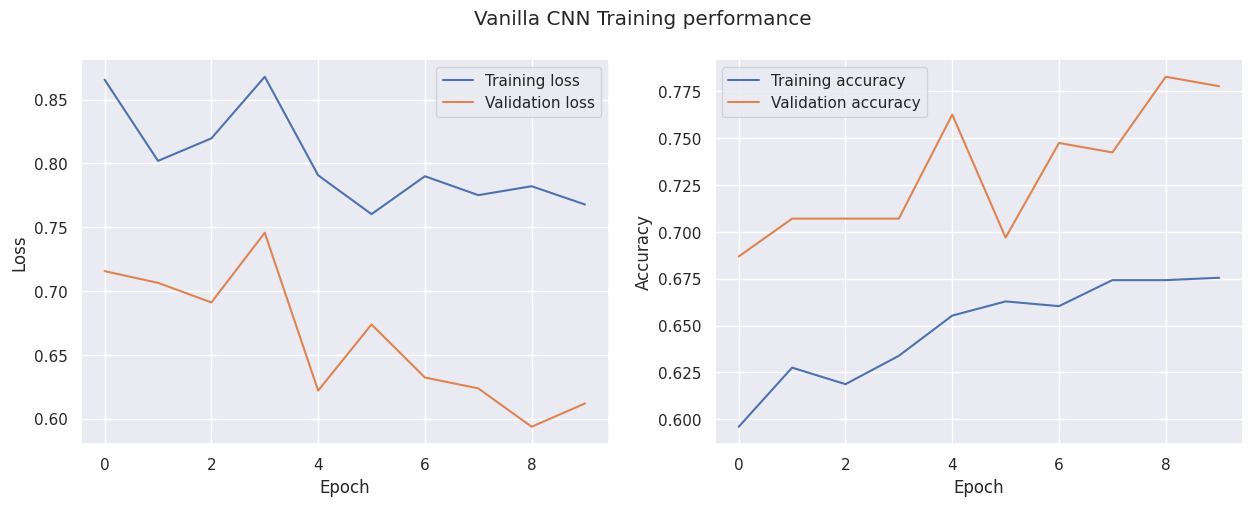

In [ ]:
plot_training_curves(cnn_history, "Vanilla CNN")

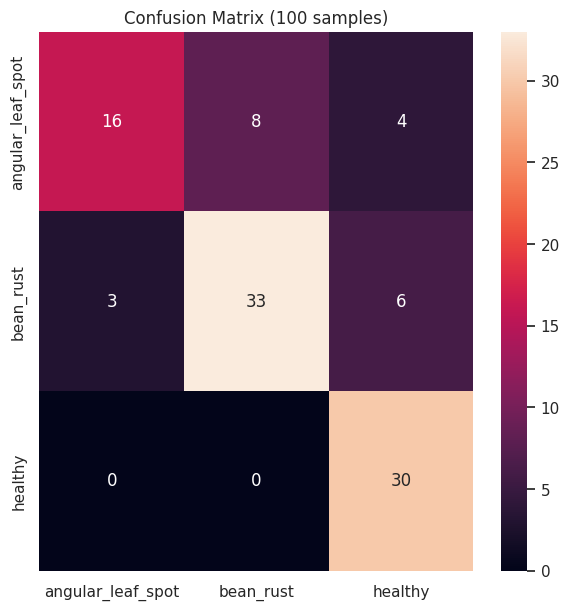



Classification Report:

                   precision    recall  f1-score   support

angular_leaf_spot       0.84      0.57      0.68        28
        bean_rust       0.80      0.79      0.80        42
          healthy       0.75      1.00      0.86        30

         accuracy                           0.79       100
        macro avg       0.80      0.79      0.78       100
     weighted avg       0.80      0.79      0.78       100



In [ ]:
cnn_ = tf.keras.models.load_model("cnn") # load best version

performance_report(val_ds, cnn_)